### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

1) MSE   $ \displaystyle \frac{dL(a(x_i), y_i)}{da(x_i)} = 2(y_i - a(x_i))$

2) Экспоненциальная    $ \displaystyle \frac{dL(a(x_i), y_i)}{da(x_i)} = y_iexp(-a(x_i)y_i)$

3) Логистическая:   $ \displaystyle \frac{dL(a(x_i), y_i)}{da(x_i)} = \frac{y_i}{exp(a(x_i)y_i) + 1}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [42]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [47]:
class ConstModel:
    
    def __init__(self, value):
        self.value = value
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        return np.full(X.shape[0], self.value)

class MyGradientBoostingClassifier:

    def __init__(self, loss="MSE", learning_rate=0.1, n_estimators=10, colsample=1, subsample=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.models = []
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.kwargs = kwargs
        
        if loss == "MSE": 
            self.set_grad = lambda x, y: 2 * (y - x)
            self.set_step = lambda new, err: LinearRegression(fit_intercept=False).fit(new.reshape(-1, 1), err).coef_[0]
        if loss == "exp":
            self.set_grad = lambda x, y: y * np.exp(-(x * y))
            self.set_step = lambda : 1
        if loss == "log":
            self.set_grad = lambda x, y: y / (1 + np.exp(x * y))
            self.set_step = lambda : 1
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        if init_model:
            self.models.append((init_model(), 1, np.arange(X.shape[1])))
            self.models[0][0].fit(X, y)
        else:
            self.models.append((ConstModel(0), 1, np.arange(X.shape[1])))
        if self.kwargs:
            get_new_model = lambda : base_model(**self.kwargs)
        else:
            get_new_model = base_model
        
        features = int(X.shape[1] * self.colsample)
        objects = int(X.shape[0] * self.subsample)
        for i in range(self.n_estimators):
            object_index = np.random.choice(X.shape[0], size=objects, replace=False)
            feature_index = np.random.choice(X.shape[1], size=features, replace=False)
            tmp_X = X[object_index, :]
            tmp_y = y[object_index]
            prev = self.predict(tmp_X)
            target = self.learning_rate * self.set_grad(prev, tmp_y)
            new_model = get_new_model()
            tmp2_X = tmp_X[:, feature_index]
            new_model.fit(tmp2_X, tmp_y)
            pred = new_model.predict(X[:, feature_index])
            prev = self.predict(X)
            step = self.set_step(pred, y - prev)
            self.models.append((new_model, step, feature_index))
        return self
        
    def predict(self, X):
        ans = np.zeros(X.shape[0])
        for i in self.models:
            ans = ans + i[1] * i[0].predict(X[:, i[2]])
        return np.around(ans)


In [51]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [52]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [53]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8333333333333334
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [115]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold, cross_val_score
import matplotlib.pyplot as plt 
X, y = fetch_california_housing(return_X_y=True)

In [116]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [118]:
est = [10, 20, 50, 100, 200] 
train = []
test = []

for n_est in est:
    clf = MyGradientBoostingClassifier(n_estimators=n_est)
    train_score = accuracy_score(y_train, clf.fit(X_train, y_train).predict(X_train))
    train.append(train_score)
    test_score = accuracy_score(y_test, clf.predict(X_test))
    test.append(test_score)

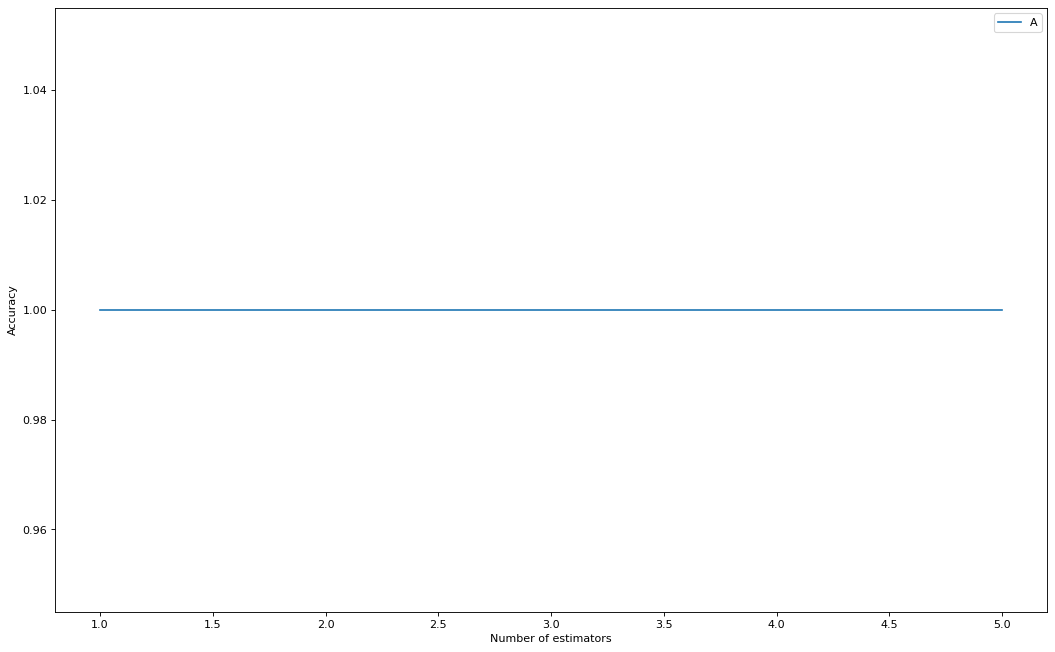

In [119]:
colors = ['r', 'g', 'b']
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.plot(np.linspace(1, 5, 5, dtype=int), train)
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Accuracy')
ax.legend('Accuracy from number of estimators', loc='upper right')
plt.show()

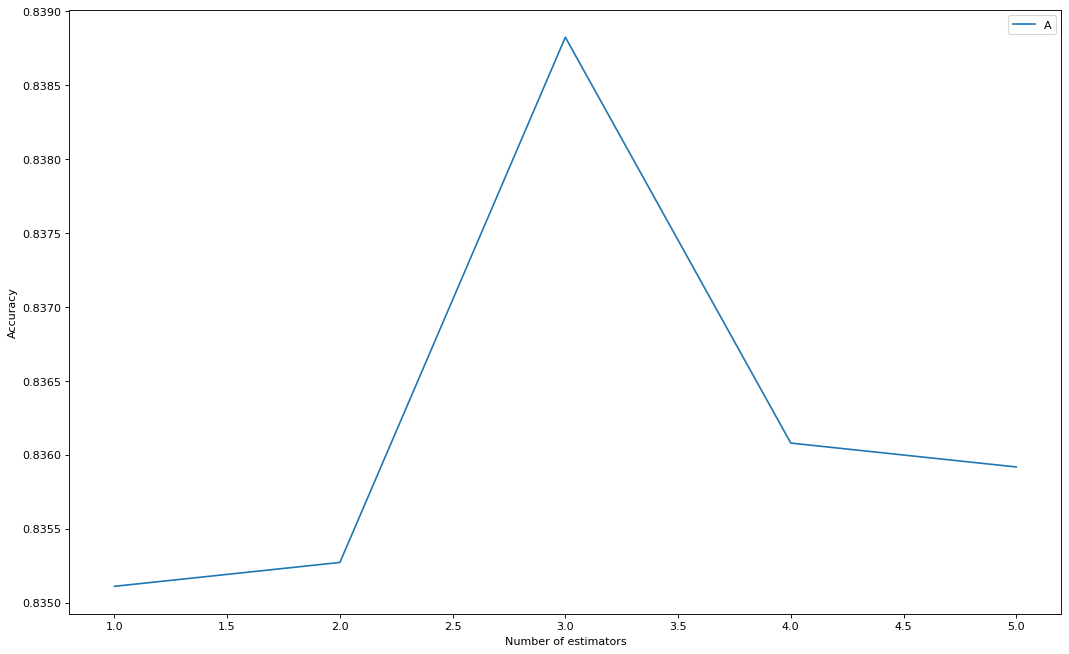

In [120]:
colors = ['r', 'g', 'b']
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.plot(np.linspace(1, 5, 5, dtype=int), test)
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Accuracy')
ax.legend('Accuracy from number of estimators', loc='upper right')
plt.show()

In [121]:
rates = [1, 0.1, 0.01, 0.005, 0.001]
train = []
test = []

for rate in rates:
    clf = MyGradientBoostingClassifier(learning_rate=rate, n_estimators=50, max_depth=4)
    train_score = accuracy_score(y_train, clf.fit(X_train, y_train).predict(X_train))
    train.append(train_score)
    test_score = accuracy_score(y_test, clf.predict(X_test))
    test.append(test_score)

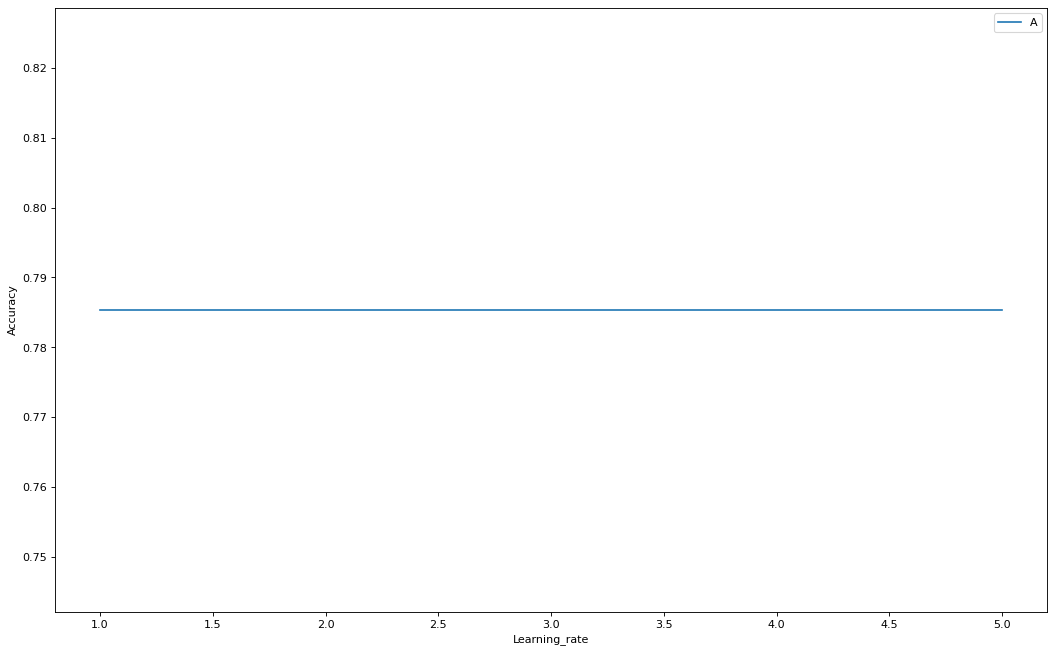

In [122]:
colors = ['r', 'g', 'b']
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.plot(np.linspace(1, 5, 5, dtype=int), train)
ax.set_xlabel('Learning_rate')
ax.set_ylabel('Accuracy')
ax.legend('Accuracy from learning_rate', loc='upper right')
plt.show()

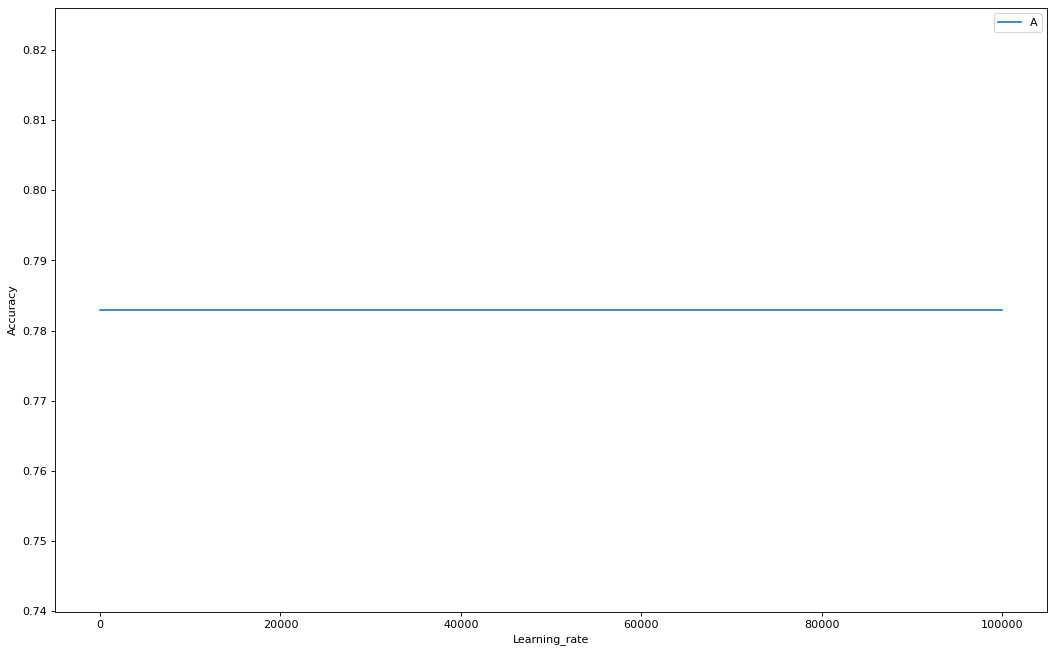

In [123]:
colors = ['r', 'g', 'b']
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.plot(np.logspace(1, 5, 5, dtype=int), test)
ax.set_xlabel('Learning_rate')
ax.set_ylabel('Accuracy')
ax.legend('Accuracy from learning_rate', loc='upper right')
plt.show()

In [124]:
colsamples = [i/10 for i in range(3, 11)]
train = []
test = []

for colsample in colsamples:
    clf = MyGradientBoostingClassifier(n_estimators=50, colsample=colsample, max_depth=4)
    train_score = accuracy_score(y_train, clf.fit(X_train, y_train).predict(X_train))
    train.append(train_score)
    test_score = accuracy_score(y_test, clf.predict(X_test))
    test.append(test_score)

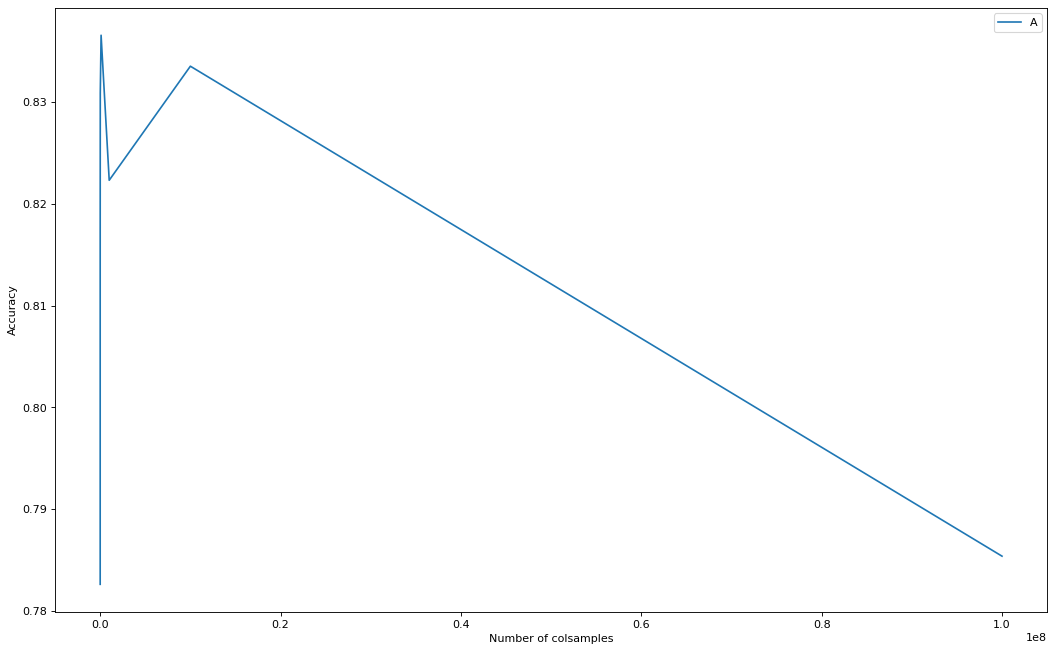

In [125]:
colors = ['r', 'g', 'b']
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.plot(np.logspace(1, 8, 8, dtype=int), train)
ax.set_xlabel('Number of colsamples')
ax.set_ylabel('Accuracy')
ax.legend('Accuracy from Number of colsamples', loc='upper right')
plt.show()

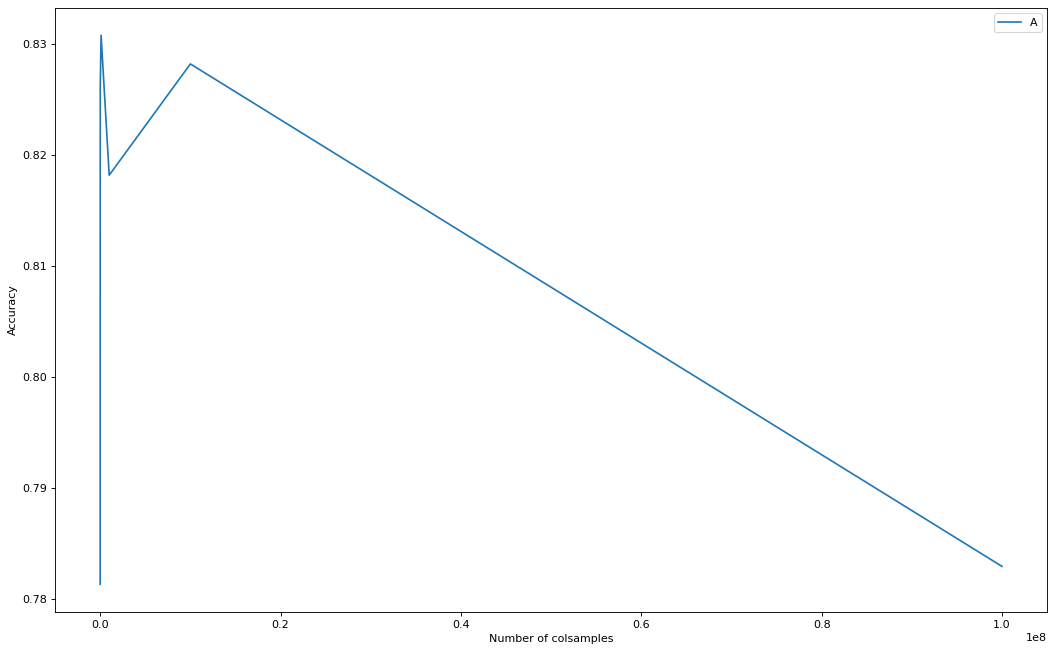

In [126]:
colors = ['r', 'g', 'b']
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.plot(np.logspace(1, 8, 8, dtype=int), test)
ax.set_xlabel('Number of colsamples')
ax.set_ylabel('Accuracy')
ax.legend('Accuracy from Number of colsamples', loc='upper right')
plt.show()

In [127]:
subsamples = [i/10 for i in range(3, 11)]
train = []
test = []

for subsample in subsamples:
    clf = MyGradientBoostingClassifier(n_estimators=50, colsample=0.9, subsample=subsample, max_depth=4)
    train_score = accuracy_score(y_train, clf.fit(X_train, y_train).predict(X_train))
    train.append(train_score)
    test_score = accuracy_score(y_test, clf.predict(X_test))
    test.append(test_score)

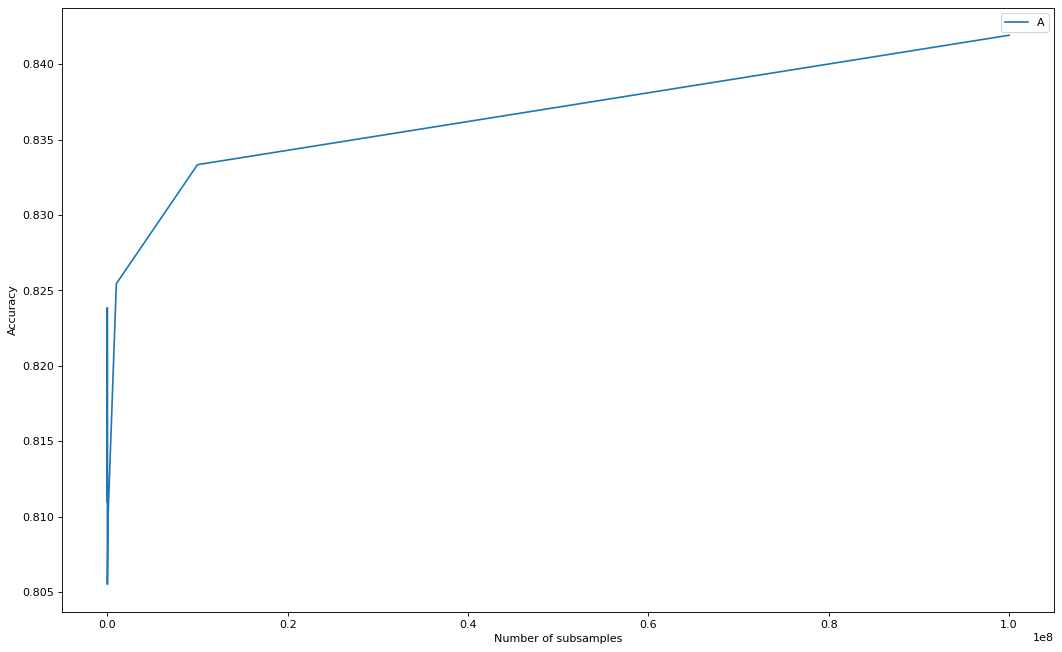

In [128]:
colors = ['r', 'g', 'b']
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.plot(np.logspace(1, 8, 8, dtype=int), train)
ax.set_xlabel('Number of subsamples')
ax.set_ylabel('Accuracy')
ax.legend('Accuracy from Number of subsamples', loc='upper right')
plt.show()

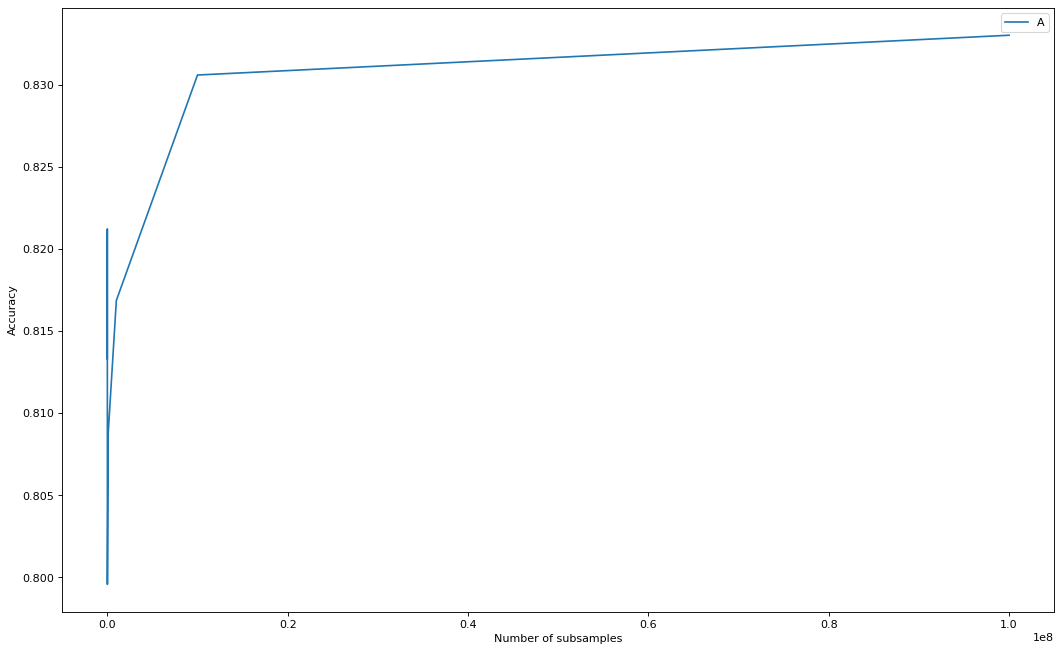

In [129]:
colors = ['r', 'g', 'b']
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.plot(np.logspace(1, 8, 8, dtype=int), test)
ax.set_xlabel('Number of subsamples')
ax.set_ylabel('Accuracy')
ax.legend('Accuracy from Number of subsamples', loc='upper right')
plt.show()

In [130]:
depths = [i for i in range(1, 10)]
train = []
test = []

for depth in depths:
    clf = MyGradientBoostingClassifier(n_estimators=50, colsample=0.6, subsample=0.9,max_depth=depth)
    train_score = accuracy_score(y_train, clf.fit(X_train, y_train).predict(X_train))
    train.append(train_score)
    test_score = accuracy_score(y_test, clf.predict(X_test))
    test.append(test_score)

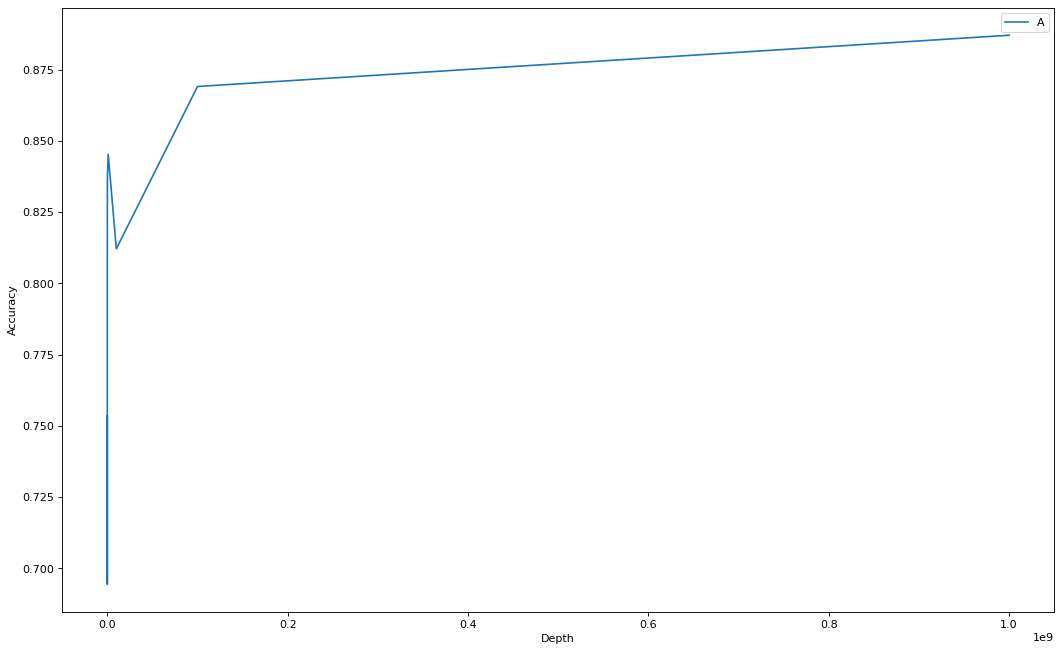

In [132]:
colors = ['r', 'g', 'b']
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.plot(np.logspace(1, 9, 9, dtype=int), train)
ax.set_xlabel('Depth')
ax.set_ylabel('Accuracy')
ax.legend('Accuracy from Depth', loc='upper right')
plt.show()

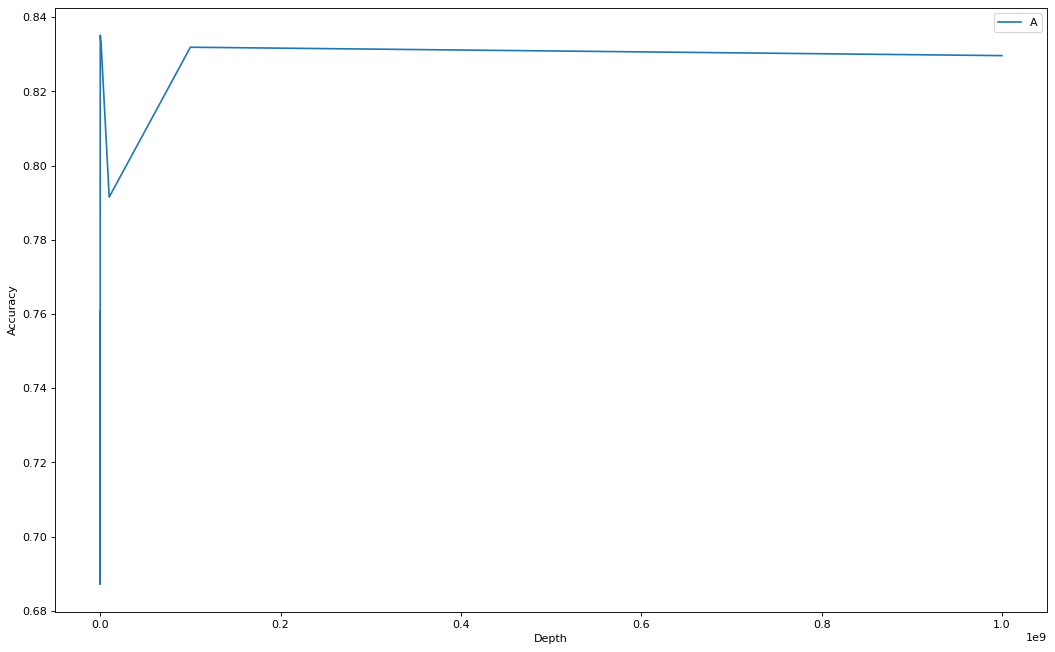

In [133]:
colors = ['r', 'g', 'b']
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.plot(np.logspace(1, 9, 9, dtype=int), test)
ax.set_xlabel('Depth')
ax.set_ylabel('Accuracy')
ax.legend('Accuracy from Depth', loc='upper right')
plt.show()

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [147]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [135]:
clf = MyGradientBoostingClassifier(n_estimators=50, colsample=0.6, subsample=0.9, max_depth=6)
clf.fit(X_train, y_train, base_model=RandomForestClassifier)
accuracy_score(y_test, clf.predict(X_test))

0.8297803617571059

In [139]:
# Видно, что качество возросло благодаря бустрапу

In [136]:
pred = []
for i in range(10):
    object_index = np.random.choice(X_train.shape[0], size=X_train.shape[0] // 2, replace=False)
    tmp_X = X_train[object_index, :]
    tmp_y = y_train[object_index]
    clf = MyGradientBoostingClassifier(n_estimators=50, colsample=0.6, subsample=0.9, max_depth=6)
    clf.fit(tmp_X, tmp_y)
    pred.append(clf.predict(X_test))

In [141]:
preds = np.array(pred)
ans = np.mean(preds, axis=0) > 0.5
ans.astype(int)
accuracy_score(y_test, ans)

0.873062015503876

In [ ]:
# Видно, что качество выросло еще (доп. уровень бустрапа)

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [137]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC

In [148]:
models = [RandomForestClassifier, LinearRegression, LinearSVC]
train = []
test = []

for i in models:
    clf = MyGradientBoostingClassifier(n_estimators=50, colsample=0.6, subsample=0.9, max_depth=6)
    train_score = accuracy_score(y_train, clf.fit(X_train, y_train, init_model=i).predict(X_train))
    train.append(train_score)
    test_score = accuracy_score(y_test, clf.predict(X_test))
    test.append(test_score)


In [150]:
print("RandomForestClassifier :", train[0], test[0])
print("LinearRegression :", train[1], test[1])
print("LinearSVC :", train[2], test[2])

RandomForestClassifier : 1.0 0.8921188630490956
LinearRegression : 0.8225359911406424 0.8225129198966409
LinearSVC : 0.6609911406423035 0.6497093023255814


In [ ]:
#Качество лучше всего на случайнмом лесе

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

